In [1]:
import pandas as pd
import os
path = os.getcwd()

In [2]:
column_titles_data = ['category', 'primary_image_url', 'all_image_urls', 'attributes', 'index']
column_titles_validation = ['A', 'B']

tsv_data = pd.read_csv("mlchallenge_set_2021.tsv", 
                       sep='\t',
                       lineterminator='\n',
                       names=column_titles_data,
                       header=None
                      )

tsv_data_validation = pd.read_csv("mlchallenge_set_validation.tsv", 
                                  sep='\t',
                                  lineterminator='\n',
                                  names=column_titles_validation,
                                  header=None
                                 )

C:\Users\resni\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
import re

def parse_attributes(df1):
    attributes = []
    for attrib in df1['attributes']:
        t1 = re.compile(":+").split(attrib[1:-1])
        for i in range(len(t1)):
            t1[i] = t1[i].split(',')
        attr = {}
        for i in range(len(t1)-1):
            if i != len(t1)-2:
                attr[t1[i][-1]] = t1[i+1][:-1]
            else:
                attr[t1[i][-1]] = t1[i+1]
        attributes.append(attr)
    df1['attributes'] = attributes

In [4]:
parse_attributes(tsv_data)

TypeError: 'float' object is not subscriptable

In [1]:
import torch
torch.cuda.is_available()

True

In [9]:
import os

import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools
from matplotlib import image
import glob as glob
from PIL import Image

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


PyTorch Version:  1.7.1
Torchvision Version:  0.8.2
Using the GPU!


In [7]:
# Download the crap that I need
from os import path
if not path.exists("./images"):
    os.mkdir("images")
    import urllib.request
    img_idx = 0
    for img in tsv_data['primary_image_url']:
        print("Downloading[{1}]: {0}".format(img, img_idx + 1))
        try:
            urllib.request.urlretrieve(img, "./images/" + str(img_idx) + '.JPG')
            if img_idx == 2000:
                break
            img_idx += 1
        except  Exception as e:
            print("Failed: {0}".format(e))

In [11]:
img_size = 256
class Edges2Shoes(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir: the directory of the dataset
            split: "train" or "val"
            transform: pytorch transformations.
        """

        self.transform = transform
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== #
        # get the the file path to all train/val images
        # Hint: the function glob.glob is useful

        self.files = glob.glob(root_dir + '/' + split + '/*')

        # ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        img = img.resize((img_size,img_size)).convert('RGB')
        img = np.asarray(img)
        if self.transform:
            img = self.transform(img)
        return img

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#
# ============== YOUR CODE HERE ============== #
# Construct the dataloader
# For the train_loader, please use a batch size of 4 and set shuffle to True
# For the test_loader, please use a batch size of 5 and set shuffle to False



tr_dt = Edges2Shoes('./images', 'train', transform)
te_dt = Edges2Shoes('./images', 'val', transform)

train_loader = DataLoader(tr_dt, batch_size=4, shuffle=True)
test_loader = DataLoader(te_dt, batch_size=5, shuffle=False)

# ============== END OF CODE ================= # 
#++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++++++++++++++++++++++++++++++++#

# Make sure that you have 1,000 training images and 100 testing images before moving on
print('Number of training images {}, number of testing images {}'.format(len(tr_dt), len(te_dt)))

Number of training images 1701, number of testing images 300


C:\Users\resni\Anaconda3\lib\site-packages\torchvision\transforms\functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


426
60
torch.Size([5, 3, 256, 0])


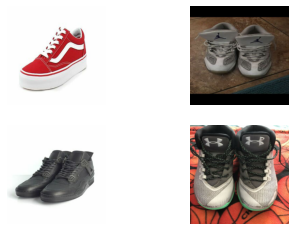

In [12]:
#Sample Output used for visualization
test = test_loader.__iter__().__next__()
fixed_y_ = test[:, :, :, img_size:].cuda()
fixed_x_ = test[:, :, :, 0:img_size].cuda()
print(len(train_loader))
print(len(test_loader))
print(fixed_y_.shape)

# plot sample image
fig, axes = plt.subplots(2, 2)
axes = np.reshape(axes, (4, ))
for i in range(4):
    example = train_loader.__iter__().__next__()[i].numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    example = std * example + mean
    axes[i].imshow(example)
    axes[i].axis('off')
plt.show()

In [13]:
def normal_init(m, mean, std):
    """
    Helper function. Initialize model parameter with given mean and std.
    """
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [14]:
class generator(nn.Module):
    # initializers
    def __init__(self):
        super(generator, self).__init__()
		#++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== #
        
        module_data = [
          ('conv1', nn.Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))),
          ('conv1_rl', nn.LeakyReLU(0.2, inplace=True)),
          ('conv2', nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))),
          ('conv2_bn', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
          ('conv2_rl', nn.LeakyReLU(0.2, inplace=True)),
          ('conv3', nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))),
          ('conv3_bn', nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
          ('conv3_rl', nn.LeakyReLU(0.2, inplace=True)),
          ('conv4', nn.Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))),
          ('conv4_bn', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
          ('conv4_rl', nn.LeakyReLU(0.2, inplace=True)),
          ('conv5', nn.Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))),
          ('conv5_ bn', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
          ('conv5_rl', nn.LeakyReLU(0.2, inplace=True)),
          ('conv6', nn.Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))),
          ('conv6_bn', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
          ('conv6_rl', nn.LeakyReLU(0.2, inplace=True)),
          ('conv7', nn.Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))),
          ('conv7_bn', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
          ('conv7_rl', nn.LeakyReLU(0.2, inplace=True)),
          ('conv8', nn.Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))),
          ('conv8_rl', nn.LeakyReLU(0.2, inplace=True)),
          ('deconv1', nn.ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))),
          ('deconv1_bn', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
          ('deconv1_rl', nn.LeakyReLU(0.2, inplace=True)),
          ('deconv2', nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))),
          ('deconv2_bn', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
          ('deconv2_rl', nn.LeakyReLU(0.2, inplace=True)),
          ('deconv3', nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))),
          ('deconv3_bn', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
          ('deconv3_rl', nn.LeakyReLU(0.2, inplace=True)),
          ('deconv4', nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))),
          ('deconv4_bn', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
          ('deconv4_rl', nn.LeakyReLU(0.2, inplace=True)),
          ('deconv5', nn.ConvTranspose2d(1024, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))),
          ('deconv5 bn', nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
          ('deconv5_rl', nn.LeakyReLU(0.2, inplace=True)),
          ('deconv6', nn.ConvTranspose2d(512, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))),
          ('deconv6_bn', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
          ('deconv6_rl', nn.LeakyReLU(0.2, inplace=True)),
          ('deconv7', nn.ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))),
          ('deconv7_bn', nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
          ('deconv7_rl', nn.LeakyReLU(0.2, inplace=True)),
          ('deconv8', nn.ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))),
          ('tanh', nn.Tanh())
        ]

        for mod in module_data:
          self.add_module(mod[0], mod[1])


        # ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== #

        relu_outputs = []
        o = input
        for m in self._modules:
            if m[0] != 'd':
                o = self._modules[m](o)
                if m[-1] == 'l' and m != 'conv8_rl':
                  relu_outputs.append(o)
            else:
                if m[-1] not in ['n', 'l', '1', 'h']:
                  t = relu_outputs.pop()
                  o = self._modules[m](torch.cat([t, o], 1))
                else:
                  o = self._modules[m](o)
        # ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#

        return o

class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== #

        module_data = [
          ('conv1', nn.Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))),
          ('conv1_rl', nn.LeakyReLU(0.2, inplace=True)),
          ('conv2', nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))),
          ('conv2_bn', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
          ('conv2_rl', nn.LeakyReLU(0.2, inplace=True)),
          ('conv3', nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))),
          ('conv3_bn', nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
          ('conv3_rl', nn.LeakyReLU(0.2, inplace=True)),
          ('conv4', nn.Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))),
          ('conv4_bn', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
          ('conv4_rl', nn.LeakyReLU(0.2, inplace=True)),
          ('conv5', nn.Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))),
          ('sigmoid', nn.Sigmoid())
        ]

        for mod in module_data:
          self.add_module(mod[0], mod[1])

        # ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#
        # ============== YOUR CODE HERE ============== # 
        x = input
        for m in self._modules:
            x = self._modules[m](x)
        # ============== END OF CODE ================= # 
        #++++++++++++++++++++++++++++++++++++++++++++++#
        #++++++++++++++++++++++++++++++++++++++++++++++#

        return x

In [15]:
# print out the model summary
G = generator().cuda()
D = discriminator().cuda()
summary(G, (3, 256, 256))
summary(D, (6, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,664
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12            [-1, 512, 8, 8]       4,194,816
      BatchNorm2d-13            [-1, 512, 8, 8]           1,024
        LeakyReLU-14            [-1, 51

In [28]:
# Helper function for showing result.
def process_image(img):
    return (img.cpu().data.numpy().transpose(1, 2, 0) + 1) / 2

def show_result(G, x_, y_, num_epoch):
    predict_images = G(x_)

    fig, ax = plt.subplots(x_.size()[0], 3, figsize=(6,10))

    for i in range(x_.size()[0]):
        ax[i, 0].get_xaxis().set_visible(False)
        ax[i, 0].get_yaxis().set_visible(False)
        ax[i, 1].get_xaxis().set_visible(False)
        ax[i, 1].get_yaxis().set_visible(False)
        #ax[i, 2].get_xaxis().set_visible(False)
        # ax[i, 2].get_yaxis().set_visible(False)
        ax[i, 0].cla()
        ax[i, 0].imshow(process_image(x_[i]))
        ax[i, 1].cla()
        ax[i, 1].imshow(process_image(predict_images[i]))
       # ax[i, 2].cla()
       # ax[i, 2].imshow(process_image(y_[i]))
    
    plt.tight_layout()
    label_epoch = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0, label_epoch, ha='center')
    label_input = 'Input'
    fig.text(0.18, 1, label_input, ha='center')
    label_output = 'Output'
    fig.text(0.5, 1, label_output, ha='center')
    label_truth = 'Ground truth'
    fig.text(0.81, 1, label_truth, ha='center')

    plt.show()

# Helper function for counting number of trainable parameters.
def count_params(model):
    '''
    Counts the number of trainable parameters in PyTorch.
    Args:
        model: PyTorch model.
    Returns:
        num_params: int, number of trainable parameters.
    '''
    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])
    return num_params

In [24]:
# Hint: you could use following loss to complete following function
BCE_loss = nn.BCELoss().cuda()
L1_loss = nn.L1Loss().cuda()

def train(G, D, num_epochs = 20, only_L1 = False):
    hist_D_losses = []
    hist_G_losses = []
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== # 
    # Adam optimizers for both the generator and 
    # the discriminator

    G_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5,0.999))
    D_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5,0.999))

    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== #

    print('training start!')
    start_time = time.time()
    for epoch in range(num_epochs):
        print('Start training epoch %d' % (epoch + 1))
        D_losses = []
        G_losses = []
        epoch_start_time = time.time()
        num_iter = 0
        for x_ in train_loader:

            y_ = torch.randn(x_.shape, dtype=torch.float, device='cuda')
            x_ = x_[:, :, :, 0:img_size]
            
            x_, y_ = x_.cuda(), y_.cuda()
            #++++++++++++++++++++++++++++++++++++++++++++++#
            #++++++++++++++++++++++++++++++++++++++++++++++#
            # ============== YOUR CODE HERE ============== # 
            #Train the discriminator

            D.zero_grad()

            fake_image = G(x_)

            input_real = torch.cat([x_, y_], 1)
            input_fake = torch.cat([x_, fake_image], 1)

            D_result_real = D(input_real).squeeze()
            D_result_fake = D(input_fake).squeeze()

            loss1 = BCE_loss(D_result_fake, torch.zeros(D_result_fake.size()).cuda())
            loss2 = BCE_loss(D_result_real, torch.ones(D_result_real.size()).cuda())

            D_train_loss = (loss1 + loss2) / 2

            D_train_loss.backward()
            D_optimizer.step()
            loss_D = D_train_loss.detach().item()

            #++++++++++++++++++++++++++++++++++++++++++++++#
            #++++++++++++++++++++++++++++++++++++++++++++++#
            # ============== YOUR CODE HERE ============== # 

            # Train the generator
            G.zero_grad()

            G_result = G(x_)
            D_input = torch.cat([x_, G_result], 1)
            D_result = D(D_input).squeeze()

            if only_L1:
                G_train_loss = L1_loss(G_result, y_)
            else:
                G_train_loss = BCE_loss(D_result, torch.ones(D_result.size()).cuda()) + 100 * L1_loss(G_result, y_)
            
            G_train_loss.backward()
            G_optimizer.step()
            loss_G = G_train_loss.detach().item()

            D_losses.append(loss_D)
            hist_D_losses.append(loss_D)
            G_losses.append(loss_G)
            hist_G_losses.append(loss_G)
            num_iter += 1
            
            
            print("Finished iteration: {0}".format(num_iter))

        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        print('[%d/%d] - using time: %.2f seconds' % ((epoch + 1), num_epochs, per_epoch_ptime))
        print('loss of discriminator D: %.3f' % (torch.mean(torch.FloatTensor(D_losses))))
        print('loss of generator G: %.3f' % (torch.mean(torch.FloatTensor(G_losses))))
        if epoch == 0 or (epoch + 1) % 5 == 0:
            with torch.no_grad():
                show_result(G, fixed_x_, fixed_y_, (epoch+1))

    end_time = time.time()
    total_ptime = end_time - start_time

    return hist_D_losses, hist_G_losses

In [29]:
# Define network
G_100 = generator()
D_100 = discriminator()
G_100.weight_init(mean=0.0, std=0.02)
D_100.weight_init(mean=0.0, std=0.02)
G_100.cuda()
D_100.cuda()
G_100.train()
D_100.train()

discriminator(
  (conv1): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_rl): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_rl): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_rl): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_rl): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (sigmoid): Sigmoid()
)

training start!
Start training epoch 1
Finished iteration: 1
Finished iteration: 2
Finished iteration: 3
Finished iteration: 4
Finished iteration: 5
Finished iteration: 6
Finished iteration: 7
Finished iteration: 8
Finished iteration: 9
Finished iteration: 10
Finished iteration: 11
Finished iteration: 12
Finished iteration: 13
Finished iteration: 14
Finished iteration: 15
Finished iteration: 16
Finished iteration: 17
Finished iteration: 18
Finished iteration: 19
Finished iteration: 20
Finished iteration: 21
Finished iteration: 22
Finished iteration: 23
Finished iteration: 24
Finished iteration: 25
Finished iteration: 26
Finished iteration: 27
Finished iteration: 28
Finished iteration: 29
Finished iteration: 30
Finished iteration: 31
Finished iteration: 32
Finished iteration: 33
Finished iteration: 34
Finished iteration: 35
Finished iteration: 36
Finished iteration: 37
Finished iteration: 38
Finished iteration: 39
Finished iteration: 40
Finished iteration: 41
Finished iteration: 42
Fini

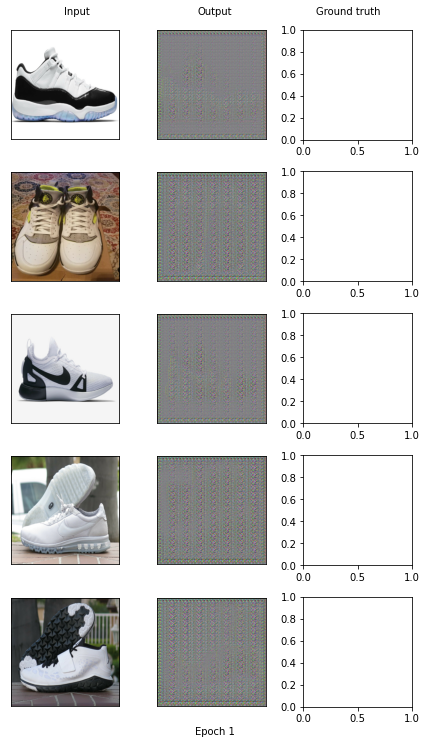

Start training epoch 2
Finished iteration: 1
Finished iteration: 2
Finished iteration: 3
Finished iteration: 4
Finished iteration: 5
Finished iteration: 6
Finished iteration: 7
Finished iteration: 8
Finished iteration: 9
Finished iteration: 10
Finished iteration: 11
Finished iteration: 12
Finished iteration: 13
Finished iteration: 14
Finished iteration: 15
Finished iteration: 16
Finished iteration: 17
Finished iteration: 18
Finished iteration: 19
Finished iteration: 20
Finished iteration: 21
Finished iteration: 22
Finished iteration: 23
Finished iteration: 24
Finished iteration: 25
Finished iteration: 26
Finished iteration: 27
Finished iteration: 28
Finished iteration: 29
Finished iteration: 30
Finished iteration: 31
Finished iteration: 32
Finished iteration: 33
Finished iteration: 34
Finished iteration: 35
Finished iteration: 36
Finished iteration: 37
Finished iteration: 38
Finished iteration: 39
Finished iteration: 40
Finished iteration: 41
Finished iteration: 42
Finished iteration: 

In [ ]:
#training
# TODO: change_num_epochs if you want
hist_D_100_losses, hist_G_100_losses = train(G_100, D_100, num_epochs = 20, only_L1 = False)

In [26]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    1598 MB |    2099 MB |     925 GB |     923 GB |\n|       from large pool |    1579 MB |    2080 MB |     911 GB |     910 GB |\n|       from small pool |      19 MB |      32 MB |      13 GB |      13 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |    1598 MB |    2099 MB |     925 GB |     923 GB |\n|       from large pool |    1579 MB |    2080 MB |